<a href="https://colab.research.google.com/github/kevwee-lab/GA-Capstone-Food-Classifier/blob/main/Capstone_Modelling%2C_Evaluation_and_ConclusionsV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelling 

Continuing from the previous notebook, we will select different categories of dessert/cake (10 classes) from the dataset. We will then proceed to build our own convolutional neural network (CNN) and fit our data onto the CNN. 

After this, we will proceed to fit our model on 2 pretrained models. We will be using VGG16 and EfficientNetB0.

In [ ]:
import os
import random
import numpy as np
import cv2
import h5py
import json
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model,load_model,Sequential
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change working directory
os.chdir('/content/gdrive/MyDrive/capstone_project/datasets/')

In [ ]:
#loading food dataframe

food_df = pd.read_csv('food_df.csv')

In [ ]:
food_df.head()

path category
0  /content/gdrive/MyDrive/capstone_project/datas...  edamame
1  /content/gdrive/MyDrive/capstone_project/datas...  edamame
2  /content/gdrive/MyDrive/capstone_project/datas...  edamame
3  /content/gdrive/MyDrive/capstone_project/datas...  edamame
4  /content/gdrive/MyDrive/capstone_project/datas...  edamame

In [ ]:
food_df.shape

(101000, 2)

In [ ]:
food_df.isnull().sum()

path        0
category    0
dtype: int64

## Train Test Split
Here we will create a train test split manually, splitting the data into 75% train, 25% test. We will also separate the data into train and validation dataframes, and shuffle the data.

In [ ]:
#create a list of categories/classes that are similar
desserts = ['baklava', 'bread pudding', 'carrot cake', 'cheesecake', 'chocolate cake',
            'creme brulee', 'cup cakes', 'red velvet cake', 'strawberry shortcake', 'tiramisu']


In [ ]:
#create 10 different dataframes for the different categories

df1 = food_df[food_df['category'] == 'baklava'] 
df2 = food_df[food_df['category'] == 'bread pudding']
df3 = food_df[food_df['category'] == 'carrot cake']
df4 = food_df[food_df['category'] == 'cheesecake']
df5 = food_df[food_df['category'] == 'chocolate cake']
df6 = food_df[food_df['category'] == 'creme brulee']
df7 = food_df[food_df['category'] == 'cup cakes']
df8 = food_df[food_df['category'] == 'red velvet cake']
df9 = food_df[food_df['category'] == 'strawberry shortcake']
df10 = food_df[food_df['category'] == 'tiramisu']


In [ ]:
# Add Class columns
df1['class'] = pd.Series([0 for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)
df6['class'] = pd.Series([5 for x in range(len(df6.index))], index=df6.index)
df7['class'] = pd.Series([6 for x in range(len(df7.index))], index=df7.index)
df8['class'] = pd.Series([7 for x in range(len(df8.index))], index=df8.index)
df9['class'] = pd.Series([8 for x in range(len(df9.index))], index=df9.index)
df10['class'] = pd.Series([9 for x in range(len(df10.index))], index=df10.index)

In [ ]:
# Split into train and validation sets
train_set_percentage = 0.75


train_df = df1[:int(len(df1)*train_set_percentage)]
val_df = df1[int(len(df1)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]

train_df6 = df6[:int(len(df6)*train_set_percentage)]
val_df6 = df6[int(len(df6)*train_set_percentage):]

train_df7 = df7[:int(len(df7)*train_set_percentage)]
val_df7 = df7[int(len(df7)*train_set_percentage):]

train_df8 = df8[:int(len(df8)*train_set_percentage)]
val_df8 = df8[int(len(df8)*train_set_percentage):]

train_df9 = df9[:int(len(df9)*train_set_percentage)]
val_df9 = df9[int(len(df9)*train_set_percentage):]

train_df10 = df10[:int(len(df10)*train_set_percentage)]
val_df10 = df10[int(len(df10)*train_set_percentage):]


#concatenate the dataframes 
df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, 
                          train_df5, train_df6, train_df7, train_df8, train_df9, train_df10])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5, 
                        val_df6, val_df7, val_df8, val_df9, val_df10])

df_new_train = df_new_train.drop(columns='category')
df_new_val = df_new_val.drop(columns='category')


#shuffle
df_train = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)


In [ ]:
df_train.shape

(7500, 2)

In [ ]:
df_val.shape

(2500, 2)

In [ ]:
df_train['class'].unique()

array([6, 3, 5, 2, 1, 8, 9, 4, 7, 0])

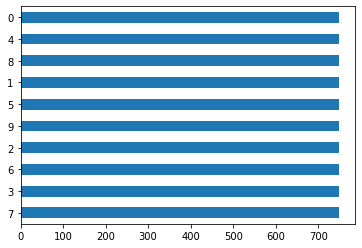

In [ ]:
#visualising the 5 classes to see if there is any imbalance
df_train['class'].value_counts().plot(kind='barh') #no imbalanced classes

In [ ]:
#saving train test dataframes into csv
df_train.to_csv('train_10.csv')
df_val.to_csv('test_10.csv')

## Data preprocessing and pipeline

At this step, we convert the training and validation dataframes into a list, and use a function to decode, resize the image and one hot encode our labels. After which we convert the images and labels into tensors, and use the tensorflow dataset method to create a dataset with the processed images and labels.

In [ ]:
df_train = pd.read_csv('train_10.csv')
df_val = pd.read_csv('test_10.csv')

In [ ]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df_train['path'].tolist()
train_labels_list = df_train['class'].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val['path'].tolist()
val_labels_list = df_val['class'].astype('int32').tolist()

#number of classes
num_classes = 10

In [ ]:
# Set up some Hyperparameters
batch_size = 32
epochs=100
lr = 0.001
img_rows, img_cols = 224, 224

In [ ]:
#function to resize image and hot encode labels
def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  #image_rescaled = image_resized / 255
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
# creating a constant tensor of filenames from list
filenames = tf.constant(train_filenames_list)

# creating a constant tensor of labels from a list
labels = tf.constant(train_labels_list)

# creating constant tensors from validation data lists
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

In [ ]:
# Assembling data pipeline 
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(32)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.batch(32)

In our earlier experimentation with VGG16, we repeated the dataset 100 times. This would inflate our dataset and cause a large increase in step size to 25,000 for training, therefore we controlled the step sizes earlier. 

We will not be doing so for the actual modelling as we have increased our classes to 10 class from 5, bringing our total training images to 7500 and validation images to 2500.

In [ ]:
# we take the first element in the dataset to print one of the labels 

for images, labels in train_dataset.take(1):
    print(labels[1])
    print(np.argmax(labels[1]))
    print(desserts[np.argmax(labels[1])])

tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
3
cheesecake


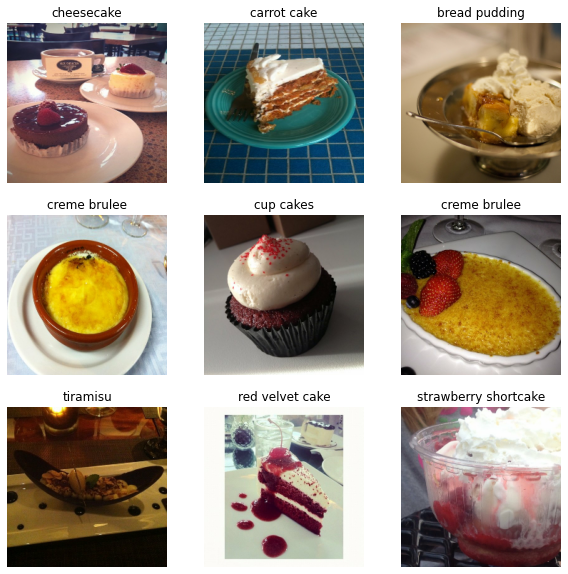

In [ ]:
#randomly view images first element of dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i, j in zip(range(9), random.sample(range(32), 9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(desserts[np.argmax(labels[j])])
        plt.axis("off")

## Modelling

### Building CNN

We will be building our own convolutional neural network to train our dataset. To control overfitting and improve model performance, we have added a batch normalization layer to the second and third block of our custom made model. Batch normalization is typically used to normalize the output of the previous layers.

In [ ]:
#building CNN model with batch normalization layers

model = Sequential([
  Rescaling(1./255, input_shape=(img_rows, img_cols, 3)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(2, 2),

  BatchNormalization(),
  Conv2D(128, 3, activation='relu'),
  MaxPool2D(2, 2),

  BatchNormalization(),
  Conv2D(256, 3, activation='relu'),
  MaxPool2D(2, 2),


  GlobalAveragePooling2D(),
  Dense(128, activation='relu'),
  Dropout(0.25),
  Dense(32, activation='relu'),
  Dropout(0.25),
  Dense(num_classes, activation='softmax')
])



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 128)       5

In [ ]:
# tf.keras optimizer
opt = optimizers.Adam(lr)

# compile the model 
model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
#create model checkpoint to save our model and weights

checkpoint = ModelCheckpoint('./checkpoints/custom_cnn_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
# early stopping if no improvement in val loss after 10 epochs

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True)

In [ ]:
# Reduce learning rate on plateau

#reduce_lr = ReduceLROnPlateau(
#    monitor='val_loss', 
#    factor=0.5, 
#    patience=10,
#    mode='auto', 
#    min_delta=0.001, 
#    min_lr= 0.0001)

We are optimizing for validation accuracy, but we must take into account validation loss as we also want a model that can generalise well on unseen data. Therefore, some of the techniques we will be using are to add batch normalization layers in our CNN and also implement early stopping.

In [ ]:
#optimise gpu allocation and performance

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)



In [ ]:
# Train the model 
history = model.fit(train_dataset, 
                   batch_size = batch_size,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/100
235/235 [==============================] - 2344s 10s/step - loss: 2.3216 - acc: 0.1390 - val_loss: 2.5155 - val_acc: 0.1000

Epoch 00001: val_loss improved from inf to 2.51550, saving model to ./checkpoints/custom_cnn_weights_01_0.10.hdf5
Epoch 2/100
235/235 [==============================] - 38s 161ms/step - loss: 2.2139 - acc: 0.1754 - val_loss: 2.4966 - val_acc: 0.1056

Epoch 00002: val_loss improved from 2.51550 to 2.49658, saving model to ./checkpoints/custom_cnn_weights_02_0.11.hdf5
Epoch 3/100
235/235 [==============================] - 38s 160ms/step - loss: 2.1332 - acc: 0.2178 - val_loss: 2.0844 - val_acc: 0.2232

Epoch 00003: val_loss improved from 2.49658 to 2.08444, saving model to ./checkpoints/custom_cnn_weights_03_0.22.hdf5
Epoch 4/100
235/235 [==============================] - 38s 162ms/step - loss: 2.0939 - acc: 0.2293 - val_loss: 1.9880 - val_acc: 0.2940

Epoch 00004: val_loss improved from 2.08444 to 1.98795, saving model to ./checkpoints/custom_cnn_weigh

### Custom CNN Model Evaluation

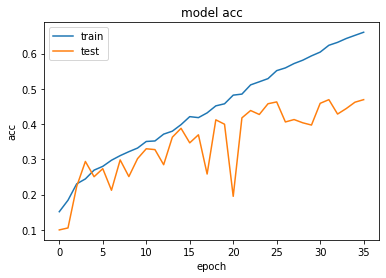

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

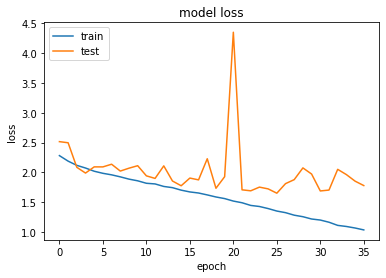

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#evaluating model accuracy
metrics = model.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

79/79 [==============================] - 9s 116ms/step - loss: 1.6499 - acc: 0.4628
model accuracy: 0.462799996137619


Our custom neural network does not seem to perform as well in terms of accuracy, compared to the 5-class base model (VGG16) we fitted earlier. We will tune our model by using keras tuner to find the best model before proceeding to use transfer learning and fit our data on pretrained models.


## Tuning CNN to optimise accuracy

We use RandomSearch from keras tuner to help us improve the accuracy scores. RandomSearch allows us to find the best parameters for the different layers of our model. In this instance, we will try to find the best parameters for our dense layers, learning rate and epochs. We will then fit our data on the tuned model and best epoch.

In [ ]:
pip install -U keras-tuner

     |████████████████████████████████| 71kB 5.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=c09a8441d7028f6b2ca720d36fbde8814d19df3769f52a7cc031df7538fb82a6
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=e79e732d730ef0d2bfa80c25eca8559051fe19a66845f1807bbb011165f10259
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# using random search to help us find best parameters for learning rate and dense layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
  Rescaling(1./255, input_shape=(img_rows, img_cols, 3)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(2, 2),

  BatchNormalization(),
  Conv2D(128, 3, activation='relu'),
  MaxPool2D(2, 2),

  BatchNormalization(),
  Conv2D(256, 3, activation='relu'),
  MaxPool2D(2, 2),

  
  GlobalAveragePooling2D(),
  Dense(hp.Choice("Dense layer", [32, 64, 128]), activation='relu'),
  Dropout(0.25),
  Dense(hp.Choice("Dense layer", [32, 64, 128]), activation='relu'),
  Dropout(0.25),
  Dense(num_classes, activation='softmax')

  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3])

  model.compile(optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='categorical_crossentropy',
                metrics=['acc'])
  return model


tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials = 6,
    directory = './params'
)

tuner.search(train_dataset, validation_data=valid_dataset, epochs=10,batch_size=32)


Trial 6 Complete [00h 06m 24s]
val_acc: 0.5723999738693237

Best val_acc So Far: 0.5795999765396118
Total elapsed time: 00h 38m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('Dense layer')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
#fit and train best model and find optimal epoch
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks=[early_stopping])
val_acc_per_epoch = history.history['val_acc']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
235/235 [==============================] - 39s 164ms/step - loss: 0.2156 - acc: 0.9367 - val_loss: 2.4974 - val_acc: 0.5644
Epoch 2/100
235/235 [==============================] - 38s 162ms/step - loss: 0.2059 - acc: 0.9364 - val_loss: 2.5262 - val_acc: 0.5660
Epoch 3/100
235/235 [==============================] - 38s 161ms/step - loss: 0.2000 - acc: 0.9422 - val_loss: 2.5627 - val_acc: 0.5644
Epoch 4/100
235/235 [==============================] - 38s 160ms/step - loss: 0.2092 - acc: 0.9357 - val_loss: 2.5897 - val_acc: 0.5736
Epoch 5/100
235/235 [==============================] - 38s 161ms/step - loss: 0.1906 - acc: 0.9404 - val_loss: 2.6082 - val_acc: 0.5696
Epoch 6/100
235/235 [==============================] - 38s 161ms/step - loss: 0.1866 - acc: 0.9439 - val_loss: 2.6902 - val_acc: 0.5672
Epoch 7/100
235/235 [==============================] - 37s 156ms/step - loss: 0.1780 - acc: 0.9472 - val_loss: 2.6307 - val_acc: 0.5680
Epoch 8/100
235/235 [===========================

In [ ]:
#refit and train with optimal epoch
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 128)       5

In [ ]:
history = hypermodel.fit(train_dataset, validation_data=valid_dataset, epochs=best_epoch, callbacks=[early_stopping])

Epoch 1/10
235/235 [==============================] - 38s 156ms/step - loss: 0.1916 - acc: 0.9384 - val_loss: 2.5672 - val_acc: 0.5616
Epoch 2/10
235/235 [==============================] - 37s 156ms/step - loss: 0.2044 - acc: 0.9381 - val_loss: 2.5591 - val_acc: 0.5724
Epoch 3/10
235/235 [==============================] - 37s 158ms/step - loss: 0.1936 - acc: 0.9427 - val_loss: 2.6576 - val_acc: 0.5760
Epoch 4/10
235/235 [==============================] - 37s 156ms/step - loss: 0.1988 - acc: 0.9402 - val_loss: 2.6314 - val_acc: 0.5680
Epoch 5/10
235/235 [==============================] - 37s 156ms/step - loss: 0.1841 - acc: 0.9451 - val_loss: 2.7244 - val_acc: 0.5668
Epoch 6/10
235/235 [==============================] - 37s 157ms/step - loss: 0.1761 - acc: 0.9456 - val_loss: 2.6580 - val_acc: 0.5680
Epoch 7/10
235/235 [==============================] - 37s 156ms/step - loss: 0.1775 - acc: 0.9440 - val_loss: 2.7226 - val_acc: 0.5672
Epoch 8/10
235/235 [==============================] - 3

### Tuned CNN Evaluation

In [ ]:
metrics = hypermodel.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

79/79 [==============================] - 9s 115ms/step - loss: 2.8083 - acc: 0.5676
model accuracy: 0.5676000118255615


After the tuning we managed to increase the accuracy to 56.7%, but this is still not ideal. We will proceed to explore using transfer learning to fit our data.

## Training VGG16

Earlier in our previous notebook on EDA and transfer learning, we used VGG16 and it gave us high accuracy for our japanese food classifier. We will now proceed to train it with 10 classes.

We will proceed to build on the VGG16 architecture as follows:
1. Remove final dense/prediction layers.
2. Create global average pooling, batch normalization, dropout and prediction layers.
3. Freeze all convolutional VGG layers.

We freeze the convolutional layers as we do not want to further modify their weights. This also helps us reduce computational time required to train our model as the backpropagation is reduced. 

In [ ]:
# create the base pre-trained model
base_vgg = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3))

 #remove the last prediction layer by declaring include_top=False

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# freeze all convolutional VGG16 layers. 
#Freezing reduces training time as the backward passes go down in number.

for layer in base_vgg.layers:
    layer.trainable = False

In [ ]:
x = base_vgg.output

#Adaptive Pooling
x = GlobalAveragePooling2D()(x) 

#batch normalization
x = BatchNormalization()(x)

#Dropout 
x = Dropout(0.2)(x)

# we use softmax here because we are predicting multiple classes
predictions = Dense(num_classes, activation='softmax')(x)


model_vgg = Model(inputs=base_vgg.input, outputs=predictions)
len(model_vgg.layers)

23

In [ ]:
for layer in model_vgg.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_1
True
batch_normalization_2
True
dropout_2
True
dense_3
True


In [ ]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# tf.keras optimizer
opt = optimizers.Adam(lr)

# compile the model 
model_vgg.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
# early stopping if no improvement in val loss after 10 epochs

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True)

In [ ]:
#create model checkpoint to save our model and weights

checkpoint = ModelCheckpoint('./checkpoints/vgg_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
# Train the model 
history_vgg = model_vgg.fit(train_dataset, 
                   epochs = epochs,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/100
235/235 [==============================] - 43s 168ms/step - loss: 2.3271 - acc: 0.2681 - val_loss: 1.5312 - val_acc: 0.4900

Epoch 00001: val_loss improved from inf to 1.53118, saving model to ./checkpoints/vgg_weights_01_0.49.hdf5
Epoch 2/100
235/235 [==============================] - 38s 160ms/step - loss: 1.4810 - acc: 0.4989 - val_loss: 1.3497 - val_acc: 0.5424

Epoch 00002: val_loss improved from 1.53118 to 1.34969, saving model to ./checkpoints/vgg_weights_02_0.54.hdf5
Epoch 3/100
235/235 [==============================] - 37s 157ms/step - loss: 1.2830 - acc: 0.5674 - val_loss: 1.2851 - val_acc: 0.5652

Epoch 00003: val_loss improved from 1.34969 to 1.28508, saving model to ./checkpoints/vgg_weights_03_0.57.hdf5
Epoch 4/100
235/235 [==============================] - 37s 157ms/step - loss: 1.1870 - acc: 0.5995 - val_loss: 1.2465 - val_acc: 0.5808

Epoch 00004: val_loss improved from 1.28508 to 1.24654, saving model to ./checkpoints/vgg_weights_04_0.58.hdf5
Epoch 5/100


Our best validation accuracy score is about 59%, which is not much of a difference from our tuned custom model. However, we did freeze the top 19 layers of VGG16 earlier when we trained our model. To further finetune and optimise for accuracy,  we will unfreeze and train some of the top layers of the CNN. This is to help our model better adapt to our dataset. 

In [ ]:
 #unfreeze layers
 base_vgg.trainable = True

#unfreeze block 5 of vgg16
for layer in base_vgg.layers[:15]:
    layer.trainable =  False

In [ ]:
for layer in model_vgg.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
True
block5_conv2
True
block5_conv3
True
block5_pool
True
global_average_pooling2d_1
True
batch_normalization_2
True
dropout_2
True
dense_3
True


In [ ]:
# compile the model 
opt = optimizers.Adam(0.0001)
model_vgg.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
# Train the model 
history_vgg_tuned = model_vgg.fit( train_dataset,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/100
235/235 [==============================] - 45s 188ms/step - loss: 1.0785 - acc: 0.6429 - val_loss: 1.2453 - val_acc: 0.6292

Epoch 00001: val_loss did not improve from 1.21291
Epoch 2/100
235/235 [==============================] - 39s 165ms/step - loss: 0.5392 - acc: 0.8258 - val_loss: 1.0022 - val_acc: 0.6696

Epoch 00002: val_loss improved from 1.21291 to 1.00224, saving model to ./checkpoints/vgg_weights_02_0.67.hdf5
Epoch 3/100
235/235 [==============================] - 39s 166ms/step - loss: 0.2549 - acc: 0.9327 - val_loss: 0.8653 - val_acc: 0.7256

Epoch 00003: val_loss improved from 1.00224 to 0.86532, saving model to ./checkpoints/vgg_weights_03_0.73.hdf5
Epoch 4/100
235/235 [==============================] - 39s 165ms/step - loss: 0.1015 - acc: 0.9854 - val_loss: 0.8524 - val_acc: 0.7408

Epoch 00004: val_loss improved from 0.86532 to 0.85238, saving model to ./checkpoints/vgg_weights_04_0.74.hdf5
Epoch 5/100
235/235 [==============================] - 39s 165ms/ste

### VGG16 evaluation

#### Untuned model

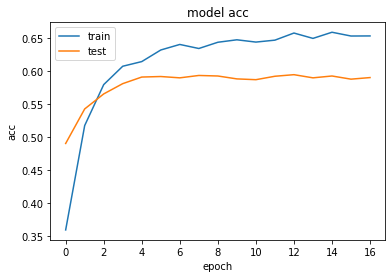

In [ ]:
plt.plot(history_vgg.history['acc'])
plt.plot(history_vgg.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

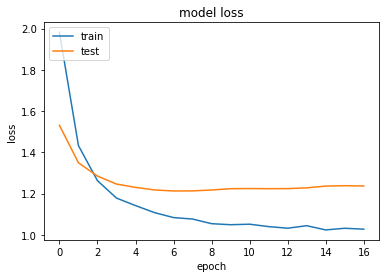

In [ ]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Tuned model

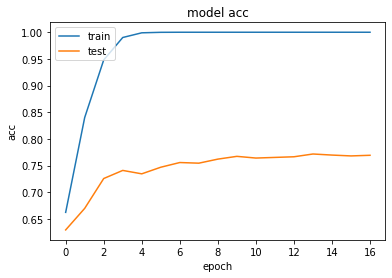

In [ ]:
plt.plot(history_vgg_tuned.history['acc'])
plt.plot(history_vgg_tuned.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

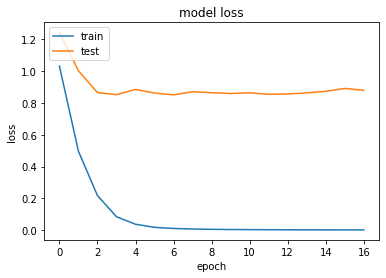

In [ ]:
plt.plot(history_vgg_tuned.history['loss'])
plt.plot(history_vgg_tuned.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#evaluating model accuracy
metrics = model_vgg.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

79/79 [==============================] - 10s 121ms/step - loss: 0.8508 - acc: 0.7556
model accuracy: 0.7555999755859375


We see that our finetuned model has achieved a validation accuracy of 75%, but it is significantly lower than our train accuracy, which has plateaued at 100% from the 6th epoch. 

## EfficientNetB0

We know from online research that EfficientNet models achieve both higher accuracy and better efficiency over existing CNNs. Therefore, we will try to fit our dataset onto EfficientNetB0. 

We will also be removing the dense/prediction layer from the model, and adding our own dense, dropout and prediction layer.

In [ ]:
#image augmentation to optimise for accuracy
from tensorflow.keras.layers.experimental import preprocessing

img_augmentation = Sequential([
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1)
])

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = img_augmentation(inputs)

In [ ]:
#importing model and removing top layers
base_b0 = tf.keras.applications.EfficientNetB0(
    include_top=False, 
    input_tensor = x,
    weights = 'imagenet',
)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
base_b0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_1[0][0]                
_____________________________________________________________________________________

In [ ]:
# freeze all b0 layers. 
#Freezing reduces training time as the backward passes go down in number.
for layer in base_b0.layers:
    layer.trainable = False

In [ ]:
#Adaptive Pooling
x = GlobalAveragePooling2D()(base_b0.output) 

#batch normalization
x = BatchNormalization()(x)

#Dropout 
x = Dropout(0.2)(x)

# we use softmax here because we are predicting multiple classes
predictions = Dense(num_classes, activation='softmax')(x)


model_b0 = Model(inputs=base_b0.input, outputs=predictions)
len(model_b0.layers)

242

In [ ]:
for layer in model_b0.layers:
    print(layer.name)
    print(layer.trainable)

input_2
False
sequential
False
rescaling_1
False
normalization
False
stem_conv_pad
False
stem_conv
False
stem_bn
False
stem_activation
False
block1a_dwconv
False
block1a_bn
False
block1a_activation
False
block1a_se_squeeze
False
block1a_se_reshape
False
block1a_se_reduce
False
block1a_se_expand
False
block1a_se_excite
False
block1a_project_conv
False
block1a_project_bn
False
block2a_expand_conv
False
block2a_expand_bn
False
block2a_expand_activation
False
block2a_dwconv_pad
False
block2a_dwconv
False
block2a_bn
False
block2a_activation
False
block2a_se_squeeze
False
block2a_se_reshape
False
block2a_se_reduce
False
block2a_se_expand
False
block2a_se_excite
False
block2a_project_conv
False
block2a_project_bn
False
block2b_expand_conv
False
block2b_expand_bn
False
block2b_expand_activation
False
block2b_dwconv
False
block2b_bn
False
block2b_activation
False
block2b_se_squeeze
False
block2b_se_reshape
False
block2b_se_reduce
False
block2b_se_expand
False
block2b_se_excite
False
block2b_pro

In [ ]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

# compile the model 
model_b0.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
# early stopping if no improvement in val loss after 5 epochs

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True)

In [ ]:
#create model checkpoint to save our model and weights

checkpoint = ModelCheckpoint('./checkpoints/b0_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
# Train the model 
history_b0 = model_b0.fit(
                   train_dataset,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping, checkpoint]
                   )

Epoch 1/100
235/235 [==============================] - 49s 177ms/step - loss: 2.0155 - acc: 0.3828 - val_loss: 1.0513 - val_acc: 0.6556

Epoch 00001: val_loss improved from inf to 1.05130, saving model to ./checkpoints/b0_weights_01_0.66.hdf5
Epoch 2/100
235/235 [==============================] - 39s 165ms/step - loss: 1.2332 - acc: 0.6013 - val_loss: 0.9585 - val_acc: 0.6888

Epoch 00002: val_loss improved from 1.05130 to 0.95852, saving model to ./checkpoints/b0_weights_02_0.69.hdf5
Epoch 3/100
235/235 [==============================] - 38s 162ms/step - loss: 1.1188 - acc: 0.6278 - val_loss: 0.9235 - val_acc: 0.7044

Epoch 00003: val_loss improved from 0.95852 to 0.92347, saving model to ./checkpoints/b0_weights_03_0.70.hdf5
Epoch 4/100
235/235 [==============================] - 38s 162ms/step - loss: 1.0384 - acc: 0.6637 - val_loss: 0.8939 - val_acc: 0.7144

Epoch 00004: val_loss improved from 0.92347 to 0.89391, saving model to ./checkpoints/b0_weights_04_0.71.hdf5
Epoch 5/100
235/

Here we see that training with EfficientNetB0 gives us a validation accuracy of around 73%. 

We may want to explore unfreezing some top layers for finetuning the model, since we froze all except for the last 4 layers we created.

However, we will keep the BatchNormalization layers frozen. If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.

In [ ]:
# We unfreeze the top 20 layers while leaving BatchNormalization layers frozen

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=opt, 
        loss="categorical_crossentropy", 
        metrics=["acc"]
        )


unfreeze_model(model_b0)

In [ ]:
checkpoint = ModelCheckpoint('./checkpoints/b0_tuned_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
for layer in model_b0.layers:
    print(layer.name)
    print(layer.trainable)

input_2
False
sequential
False
rescaling_1
False
normalization
False
stem_conv_pad
False
stem_conv
False
stem_bn
False
stem_activation
False
block1a_dwconv
False
block1a_bn
False
block1a_activation
False
block1a_se_squeeze
False
block1a_se_reshape
False
block1a_se_reduce
False
block1a_se_expand
False
block1a_se_excite
False
block1a_project_conv
False
block1a_project_bn
False
block2a_expand_conv
False
block2a_expand_bn
False
block2a_expand_activation
False
block2a_dwconv_pad
False
block2a_dwconv
False
block2a_bn
False
block2a_activation
False
block2a_se_squeeze
False
block2a_se_reshape
False
block2a_se_reduce
False
block2a_se_expand
False
block2a_se_excite
False
block2a_project_conv
False
block2a_project_bn
False
block2b_expand_conv
False
block2b_expand_bn
False
block2b_expand_activation
False
block2b_dwconv
False
block2b_bn
False
block2b_activation
False
block2b_se_squeeze
False
block2b_se_reshape
False
block2b_se_reduce
False
block2b_se_expand
False
block2b_se_excite
False
block2b_pro

In [ ]:
# Train the model 
history_b0_tuned = model_b0.fit( train_dataset,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping,checkpoint])

Epoch 1/100
235/235 [==============================] - 47s 170ms/step - loss: 0.8398 - acc: 0.7235 - val_loss: 0.8086 - val_acc: 0.7560

Epoch 00001: val_loss improved from inf to 0.80865, saving model to ./checkpoints/b0_tuned_weights_01_0.76.hdf5
Epoch 2/100
235/235 [==============================] - 39s 164ms/step - loss: 0.7456 - acc: 0.7536 - val_loss: 0.8034 - val_acc: 0.7560

Epoch 00002: val_loss improved from 0.80865 to 0.80340, saving model to ./checkpoints/b0_tuned_weights_02_0.76.hdf5
Epoch 3/100
235/235 [==============================] - 39s 165ms/step - loss: 0.6747 - acc: 0.7688 - val_loss: 0.7870 - val_acc: 0.7544

Epoch 00003: val_loss improved from 0.80340 to 0.78697, saving model to ./checkpoints/b0_tuned_weights_03_0.75.hdf5
Epoch 4/100
235/235 [==============================] - 39s 164ms/step - loss: 0.6057 - acc: 0.7923 - val_loss: 0.7795 - val_acc: 0.7652

Epoch 00004: val_loss improved from 0.78697 to 0.77947, saving model to ./checkpoints/b0_tuned_weights_04_0.

### EfficientNet B0 evaluation

#### Untuned model

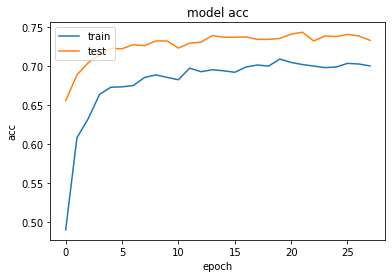

In [ ]:
plt.plot(history_b0.history['acc'])
plt.plot(history_b0.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

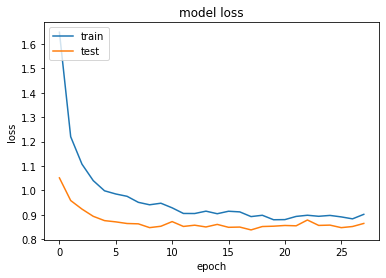

In [ ]:
plt.plot(history_b0.history['loss'])
plt.plot(history_b0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Tuned model

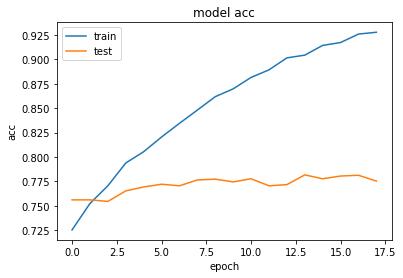

In [ ]:
plt.plot(history_b0_tuned.history['acc'])
plt.plot(history_b0_tuned.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

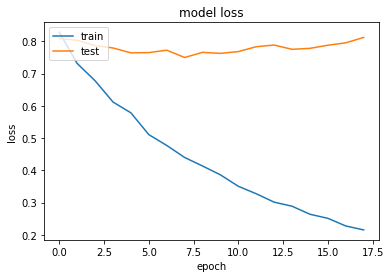

In [ ]:
plt.plot(history_b0_tuned.history['loss'])
plt.plot(history_b0_tuned.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#evaluating model accuracy
metrics = model_b0.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

79/79 [==============================] - 9s 119ms/step - loss: 0.7500 - acc: 0.7764
model accuracy: 0.7764000296592712


After unfreezing some layers and retraining the model, we achieved an improvement in validation accuracy from 73% to 77%. As such, we will use the previously untuned EfficientNetB0 as our final model, considering validation loss and validation accuracy.

## Analysing best model

We see that EfficientNetB0 seems like our best model. We will proceed to analyse the model and see how well it generalises to unseen data.

### Confusion Matrix 

We will plot a confusion matrix to look as a prelude to our analysis of misclassified images. This will also allow us to look at how accurately our model predicts the different classes.

In [ ]:
# predict the validation dataset

preds = model_b0.predict(valid_dataset)
preds = preds.argmax(axis=-1)


preds.shape

(2500,)

In [ ]:
#creating a test labels list to plot confusion matrix
test_labels = val_labels_list[0:2500]

In [ ]:
#plotting a confusion matrix to visualise the model predictions

from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdBu):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.888 0.032 0.008 0.024 0.02  0.004 0.008 0.    0.    0.016]
 [0.052 0.772 0.012 0.044 0.032 0.012 0.    0.    0.06  0.016]
 [0.048 0.04  0.668 0.052 0.052 0.012 0.008 0.024 0.024 0.072]
 [0.016 0.028 0.032 0.716 0.04  0.024 0.028 0.008 0.052 0.056]
 [0.004 0.028 0.016 0.072 0.76  0.012 0.008 0.036 0.008 0.056]
 [0.004 0.056 0.008 0.048 0.008 0.848 0.    0.    0.008 0.02 ]
 [0.004 0.016 0.032 0.024 0.024 0.    0.852 0.024 0.02  0.004]
 [0.004 0.004 0.052 0.016 0.044 0.004 0.056 0.788 0.016 0.016]
 [0.004 0.056 0.    0.132 0.004 0.008 0.016 0.028 0.74  0.012]
 [0.016 0.036 0.032 0.06  0.088 0.012 0.008 0.008 0.008 0.732]]


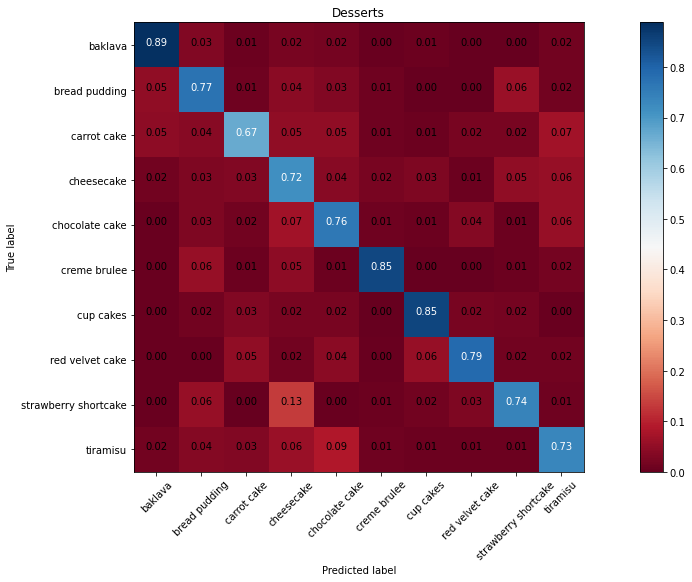

In [ ]:
cm_plot_labels = desserts

# Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Desserts')
plt.show()

From the confusion matrix, we see that it can predict most classes reasonably well, with the exception of carrot cake. We also see that tiramisu is most often misclassified as chocolate cake and strawberry shortcake is most often misclassified as cheese cake. This seems to be quite a reasonable misclassification. We will now drill down deeper into the model and look at what types of images are mostly misclassified.

### Further analysis on misclassified images

In [ ]:
# add predicted labels to validation dataframe we created earlier
df_val['predicted'] = preds

df_val.head()

Unnamed: 0  ... predicted
0           0  ...         3
1           1  ...         8
2           2  ...         1
3           3  ...         8
4           4  ...         3

[5 rows x 4 columns]

In [ ]:
# create missclassified column

df_val['misclassified'] =  np.where(df_val['class'] == df_val['predicted'], False, True)

df_val.head()

Unnamed: 0  ... misclassified
0           0  ...         False
1           1  ...         False
2           2  ...         False
3           3  ...         False
4           4  ...          True

[5 rows x 5 columns]

In [ ]:
df_val.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
#show misclassified images

df_val[df_val['misclassified']== True]

path  ...  misclassified
4     /content/gdrive/MyDrive/capstone_project/datas...  ...           True
6     /content/gdrive/MyDrive/capstone_project/datas...  ...           True
13    /content/gdrive/MyDrive/capstone_project/datas...  ...           True
14    /content/gdrive/MyDrive/capstone_project/datas...  ...           True
15    /content/gdrive/MyDrive/capstone_project/datas...  ...           True
...                                                 ...  ...            ...
2470  /content/gdrive/MyDrive/capstone_project/datas...  ...           True
2473  /content/gdrive/MyDrive/capstone_project/datas...  ...           True
2475  /content/gdrive/MyDrive/capstone_project/datas...  ...           True
2489  /content/gdrive/MyDrive/capstone_project/datas...  ...           True
2490  /content/gdrive/MyDrive/capstone_project/datas...  ...           True

[559 rows x 4 columns]

We have a total of 559 misclassified images.

In [ ]:
df_val.groupby('class')['misclassified'].value_counts()

class  misclassified
0      False            222
       True              28
1      False            193
       True              57
2      False            167
       True              83
3      False            179
       True              71
4      False            190
       True              60
5      False            212
       True              38
6      False            213
       True              37
7      False            197
       True              53
8      False            185
       True              65
9      False            183
       True              67
Name: misclassified, dtype: int64

We can see that carrot cake (class 2) gets misclassified most often, followed by cheese cake (class 3) and tiramisu (class 9) .

In [ ]:
desserts

['baklava',
 'bread pudding',
 'carrot cake',
 'cheesecake',
 'chocolate cake',
 'creme brulee',
 'cup cakes',
 'red velvet cake',
 'strawberry shortcake',
 'tiramisu']

In [ ]:
#visualising misclassified images

df_val['labels'] = df_val['class'].map( {0: 'baklava', 1: 'bread pudding', 2: 'carrot cake',
                                         3: 'cheesecake', 4: 'chocolate cake', 5: 'creme brulee',
                                         6: 'cup cakes', 7: 'red velvet cake', 8: 'strawberry shortcake',
                                         9: 'tiramisu'
                                         }
    
)

df_val.head()

path  ...                labels
0  /content/gdrive/MyDrive/capstone_project/datas...  ...            cheesecake
1  /content/gdrive/MyDrive/capstone_project/datas...  ...  strawberry shortcake
2  /content/gdrive/MyDrive/capstone_project/datas...  ...         bread pudding
3  /content/gdrive/MyDrive/capstone_project/datas...  ...  strawberry shortcake
4  /content/gdrive/MyDrive/capstone_project/datas...  ...           carrot cake

[5 rows x 5 columns]

In [ ]:
misclass_df = df_val[df_val['misclassified']==True]
misclass_df.head()

path  ...         labels
4   /content/gdrive/MyDrive/capstone_project/datas...  ...    carrot cake
6   /content/gdrive/MyDrive/capstone_project/datas...  ...     cheesecake
13  /content/gdrive/MyDrive/capstone_project/datas...  ...  bread pudding
14  /content/gdrive/MyDrive/capstone_project/datas...  ...  bread pudding
15  /content/gdrive/MyDrive/capstone_project/datas...  ...    carrot cake

[5 rows x 5 columns]

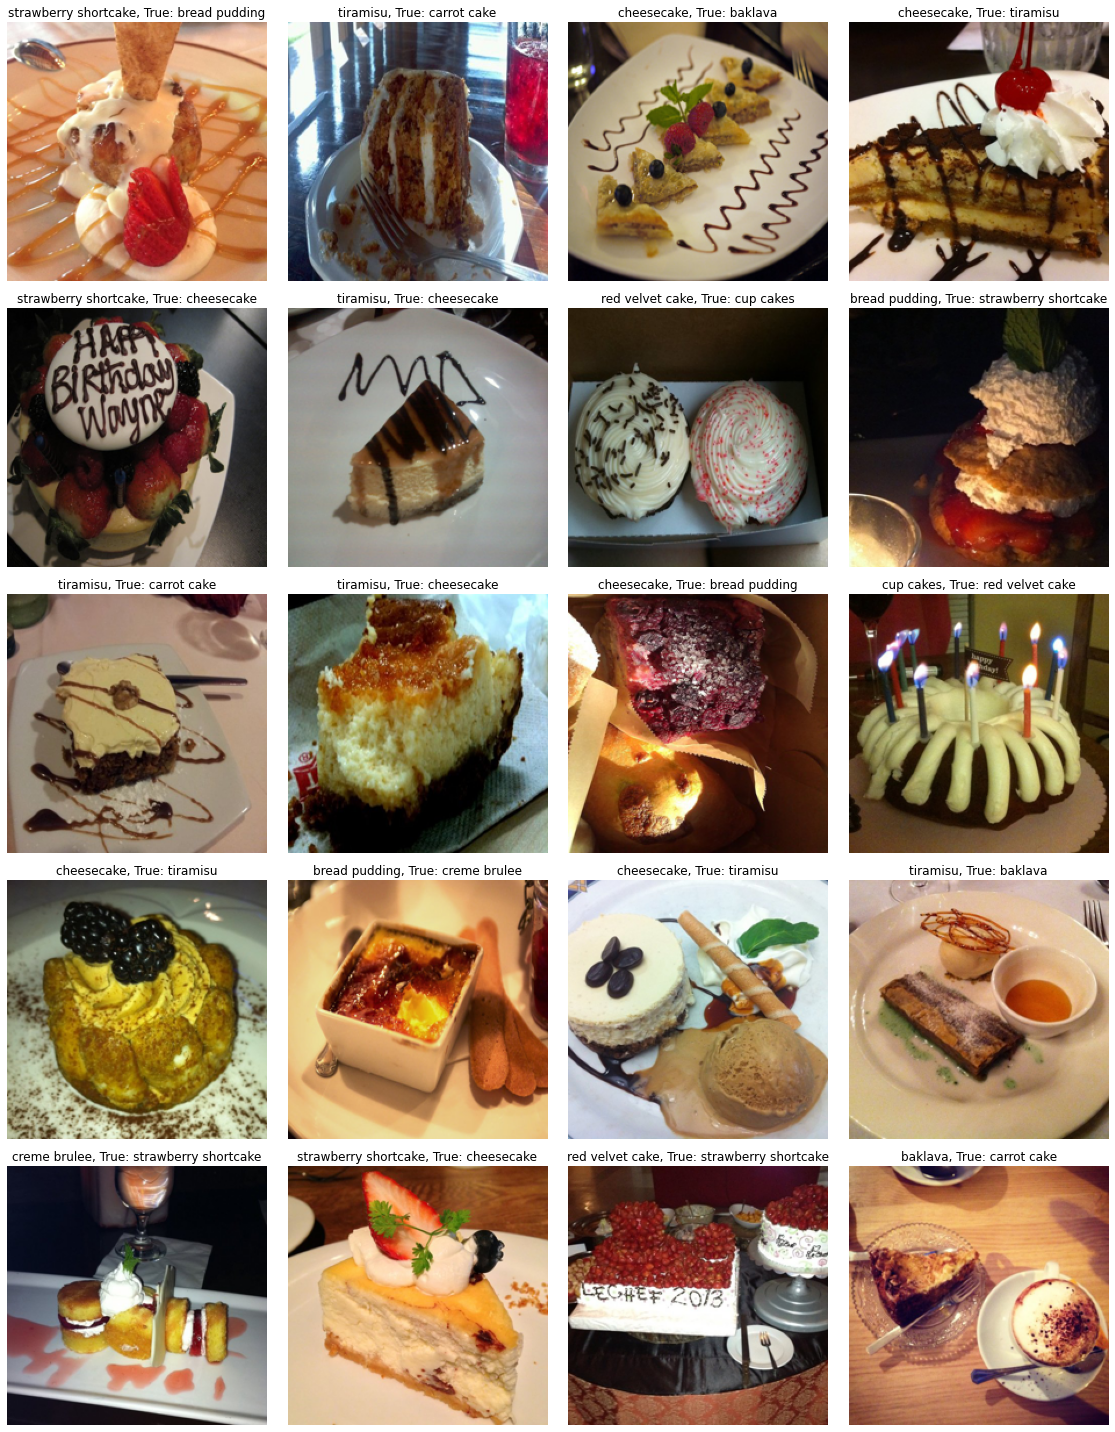

In [ ]:
import PIL.Image

plt.figure(figsize=(16, 20))

for i, j in zip(range(20), random.sample(set(misclass_df.index), 20)):
    
    ax = plt.subplot(5, 4, i + 1)
    
    image_dir = misclass_df['path'][j]

    image = PIL.Image.open(image_dir).resize((224, 224))
    prediction = misclass_df['predicted'][j]
    dessert_label = misclass_df['labels'][j]
    
    plt.imshow(image)
    plt.title(desserts[prediction]+ ', True: ' + dessert_label)
    plt.axis("off")
    plt.tight_layout()

We see from some of the misclassified images that the misclassification seems reasonable.  The lighting of some of the images and extra ingredients/sauces on food seems to also cause our model to misclassify the food classes, especially in one of the images when it predicted strawberry shortcake when the true class was a cheesecake.

## Testing our model on unseen data

We have seen the misclassified images and deemed them to be reasonable misclassifications. We will now test our model to see how well it generalises against unseen data. For this we have downloaded some images from google and unsplash to see if our best model correctly predicts the different classes.

### Predicting tiramisu

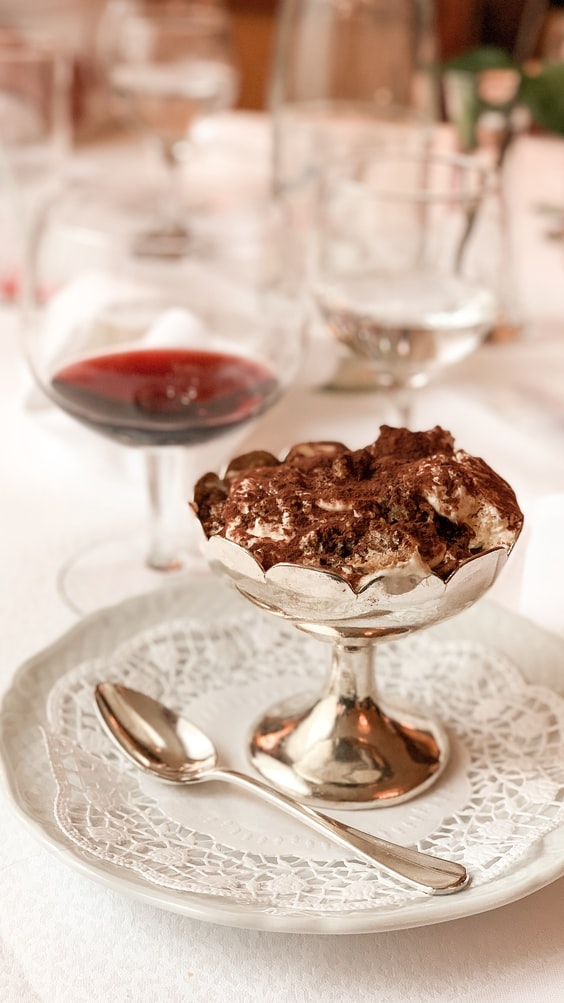

In [ ]:
#downloaded picture from unsplash
from IPython.display import Image

image_name = './googled images to test model/tiramisu.jpg'
Image(image_name)

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[4.1419910e-03 5.9492993e-03 4.4879067e-04 1.4165197e-02 1.0243078e-02
  1.0405401e-02 5.6805351e-04 5.8848818e-04 1.1237639e-03 9.5236599e-01]]
9


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

tiramisu


### Predicting creme brulee

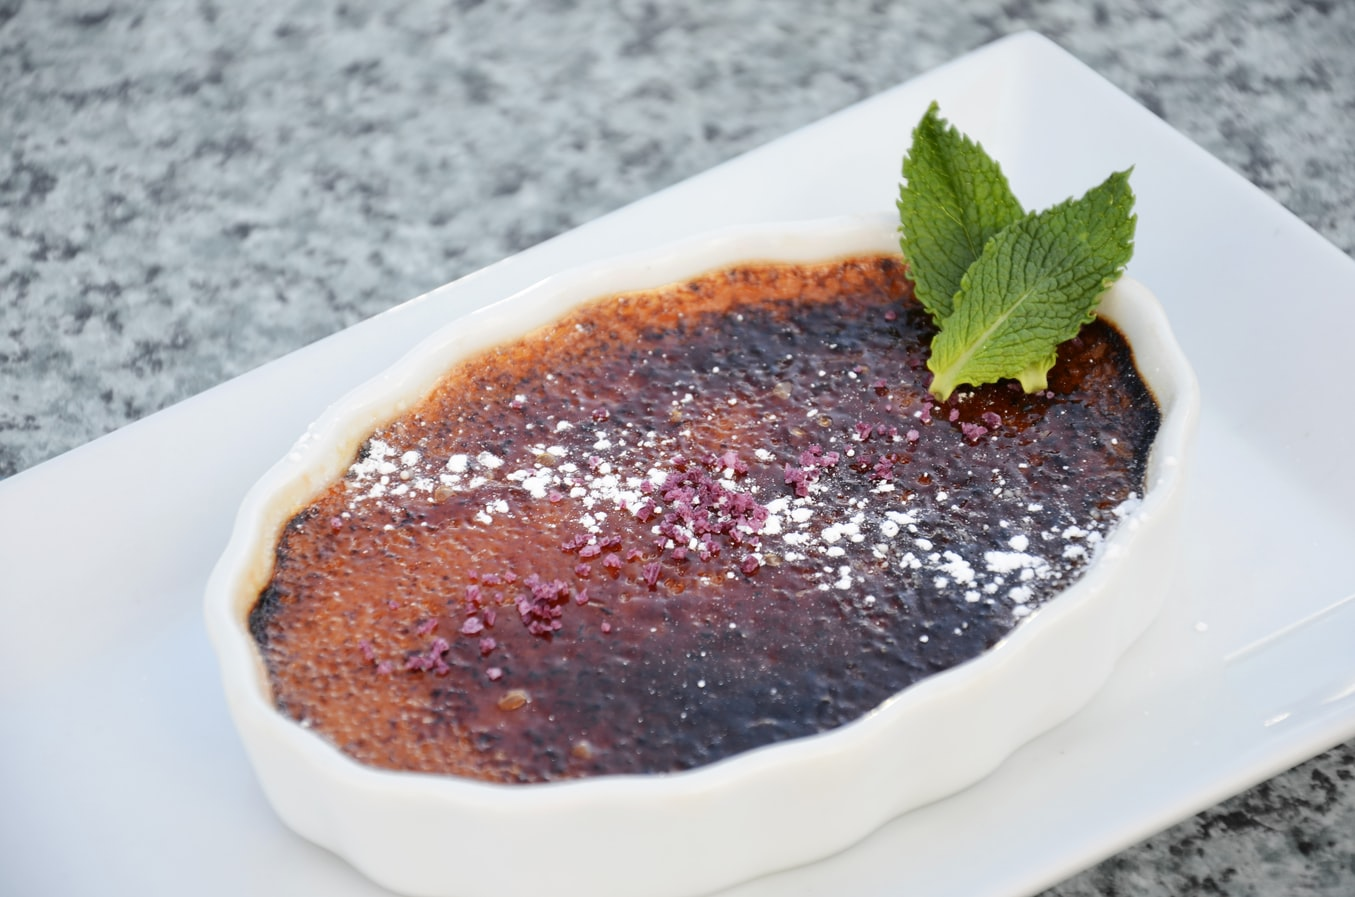

In [ ]:
image2_name = './googled images to test model/creme.jpg'
Image(image2_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image2_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.0277041e-06 1.3373253e-05 4.5221589e-07 1.6859690e-04 1.8060067e-03
  9.9349046e-01 1.1427835e-07 2.7460826e-06 7.2594065e-07 4.5166146e-03]]
5


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

creme brulee


### Predicting cupcakes

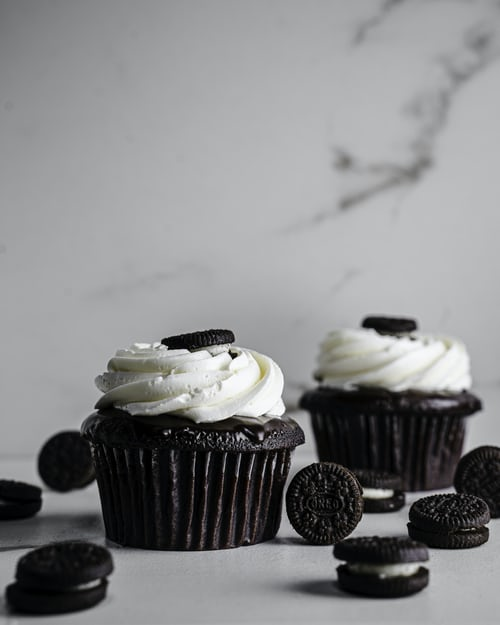

In [ ]:
image3_name = './googled images to test model/cup.jpg'
Image(image3_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image3_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.7798673e-04 7.7259137e-06 9.0760076e-03 3.9903307e-04 1.4371432e-03
  8.0984946e-06 9.8450100e-01 3.9840927e-03 4.3645423e-06 4.0459359e-04]]
6


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

cup cakes


### Predicting chocolate cake

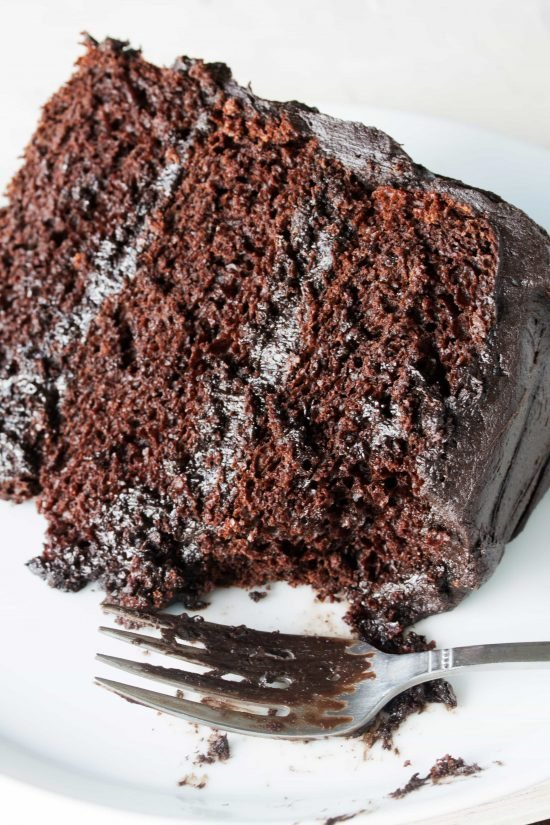

In [ ]:
image4_name = './googled images to test model/choccy.jpg'
Image(image4_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image4_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[4.1362063e-07 1.0853384e-03 4.4223500e-04 4.1738525e-03 5.8477300e-01
  9.3272472e-05 3.0621857e-04 3.5178250e-01 6.4883781e-05 5.7278331e-02]]
4


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

chocolate cake


### Predicting strawberry shortcake

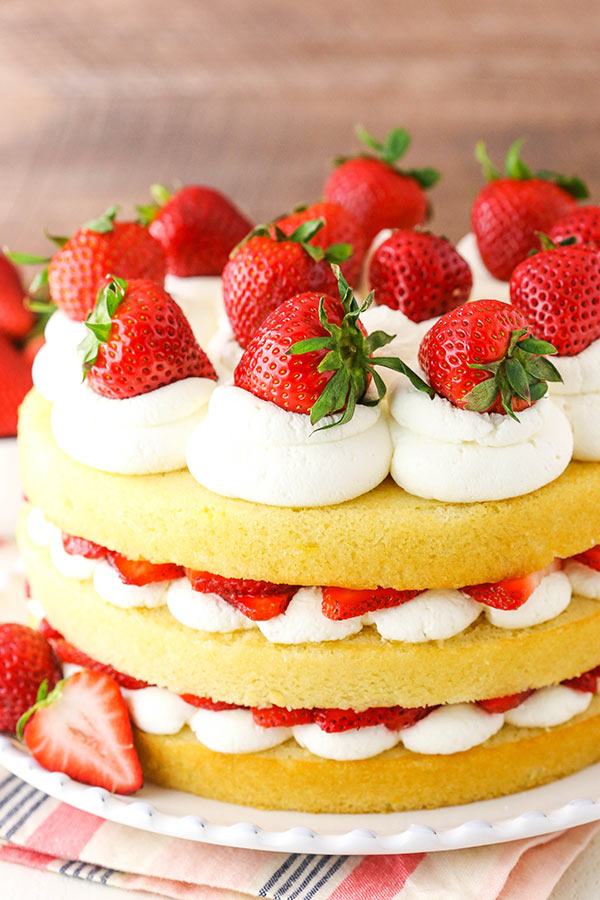

In [ ]:
image5_name = './googled images to test model/ssc.jpg'
Image(image5_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image5_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[3.06715810e-06 4.57028532e-03 1.36434042e-03 5.54868113e-03
  6.44430867e-04 4.83136129e-04 1.08437045e-02 1.41172465e-02
  9.60894167e-01 1.53090060e-03]]
8


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

strawberry shortcake


### Predicting baklava

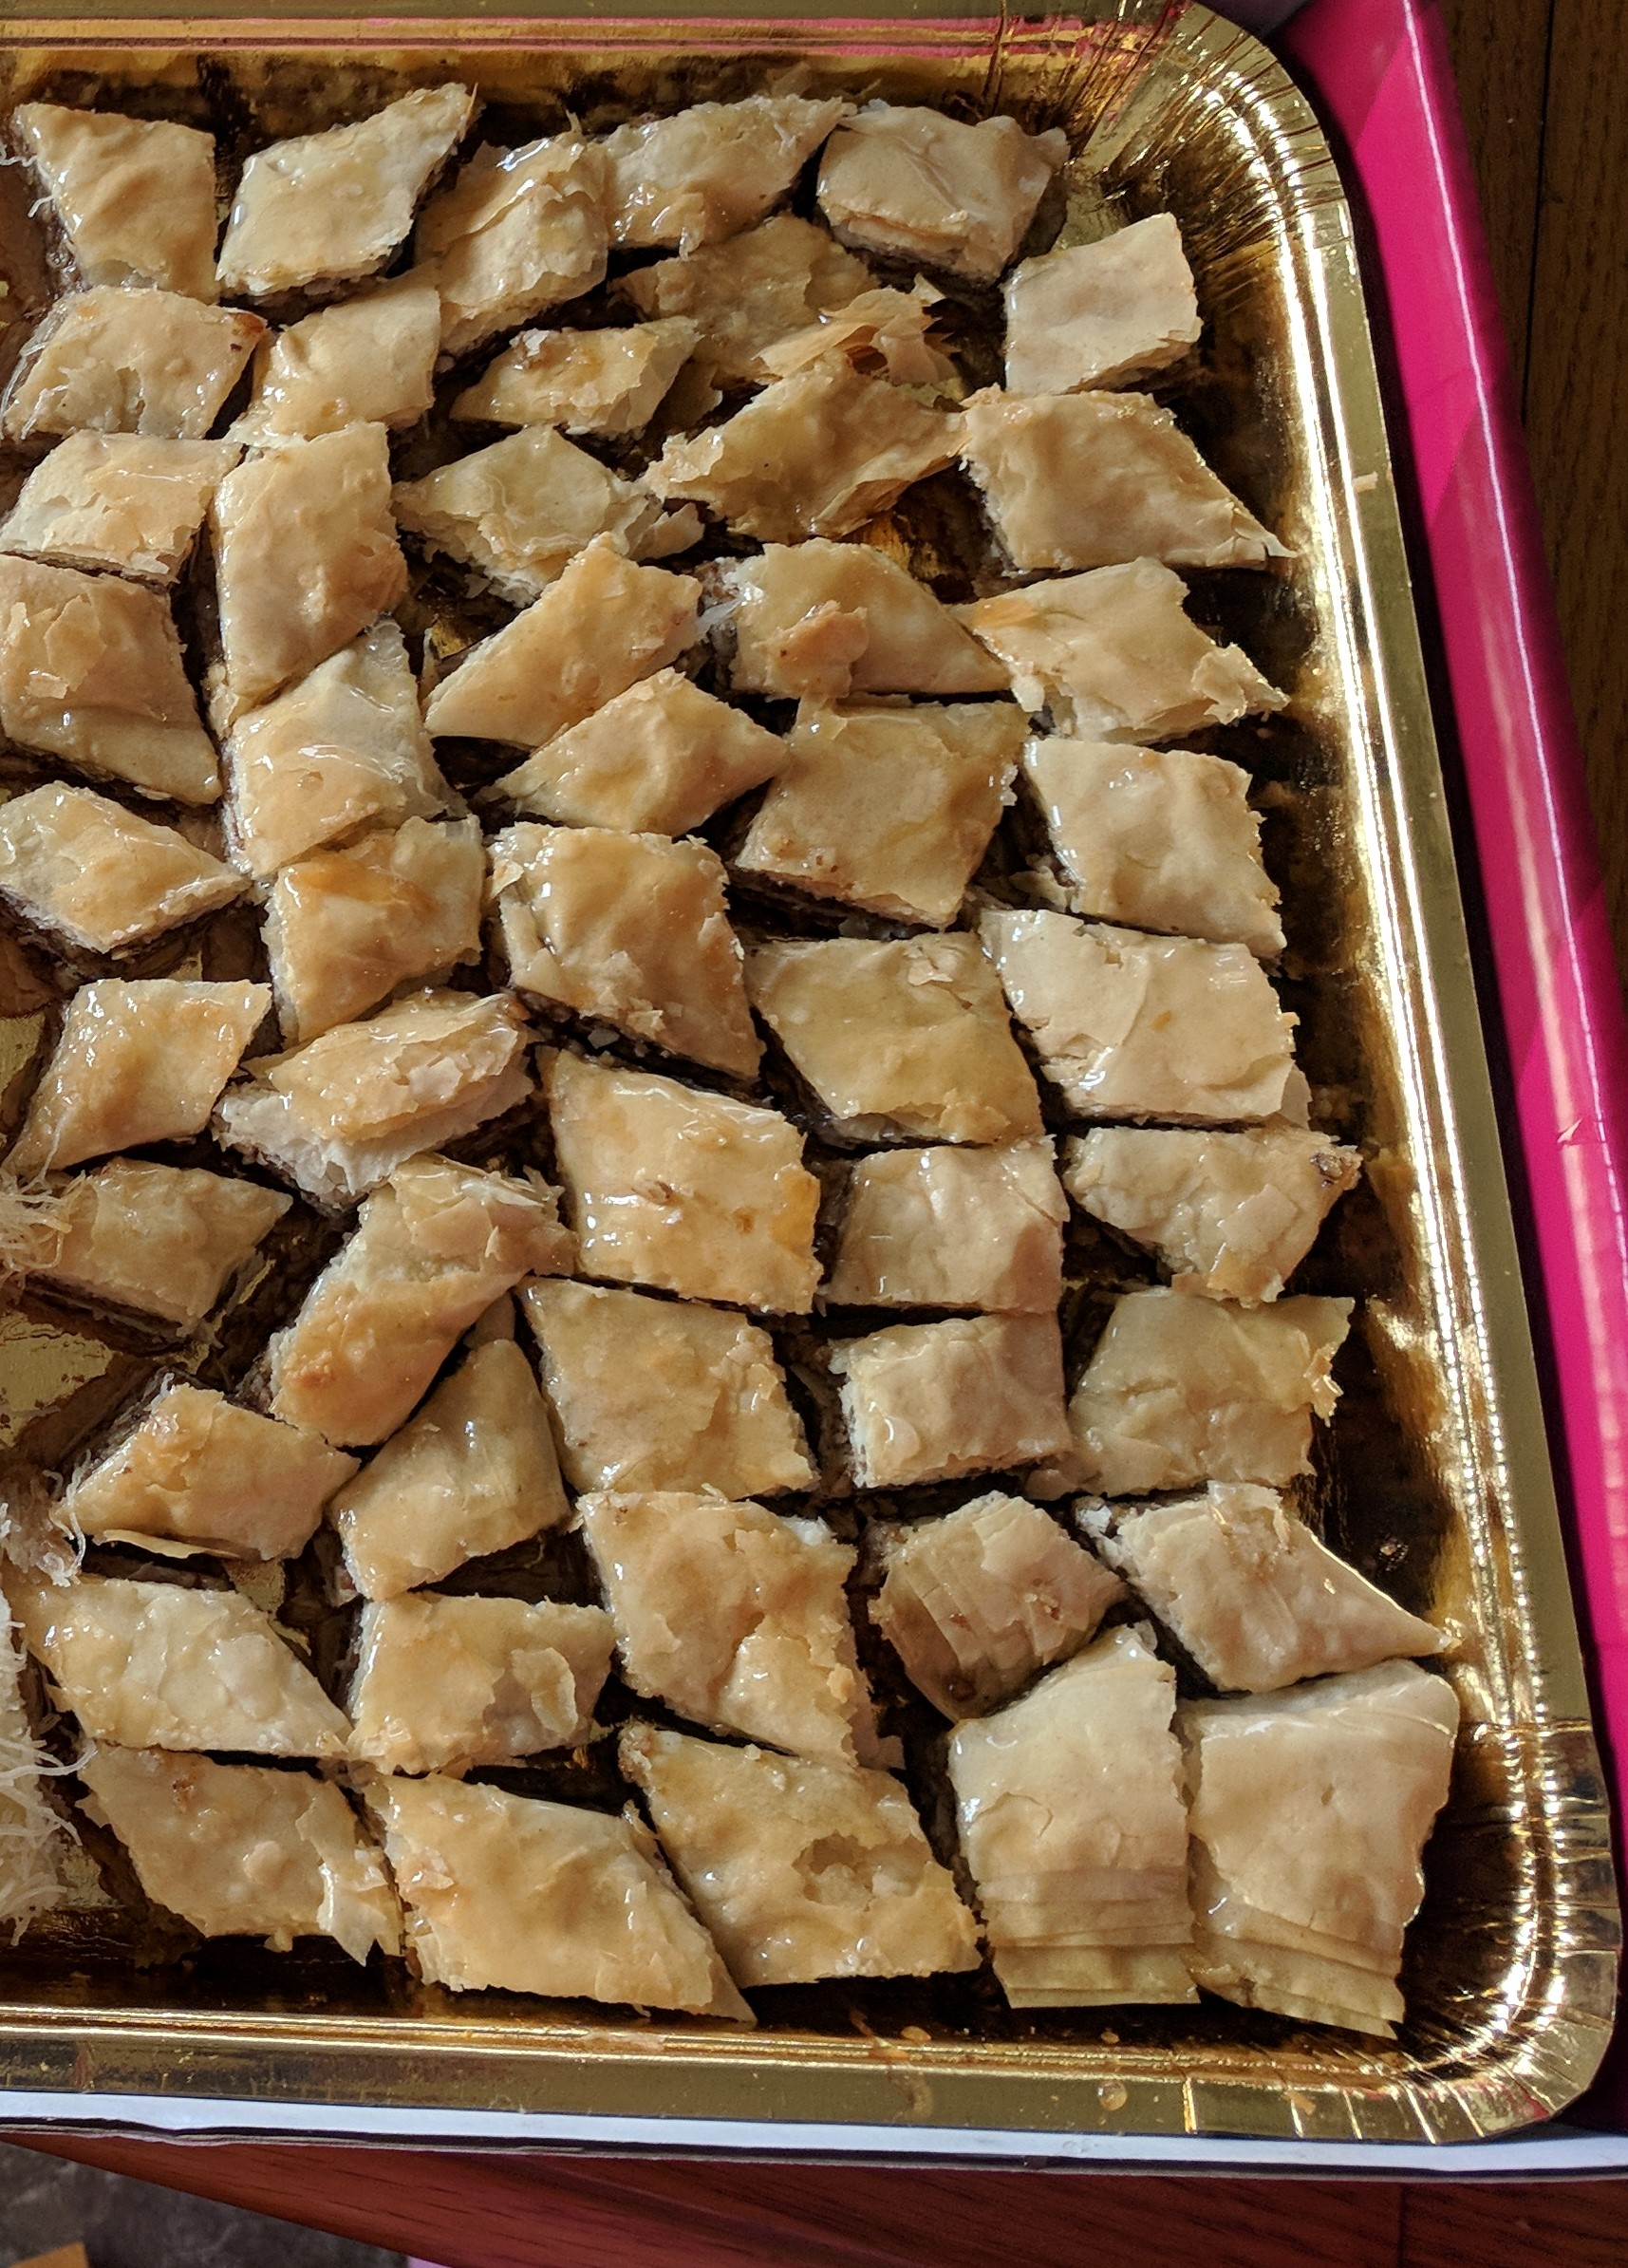

In [ ]:
image6_name = './googled images to test model/bakl.jpg'
Image(image6_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image6_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[9.9999511e-01 7.8080996e-07 5.6329219e-07 3.2502705e-08 2.5440311e-06
  5.7793603e-10 9.2414840e-11 8.2169205e-09 2.7326465e-08 9.2368418e-07]]
0


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

baklava


### Predicting bread pudding

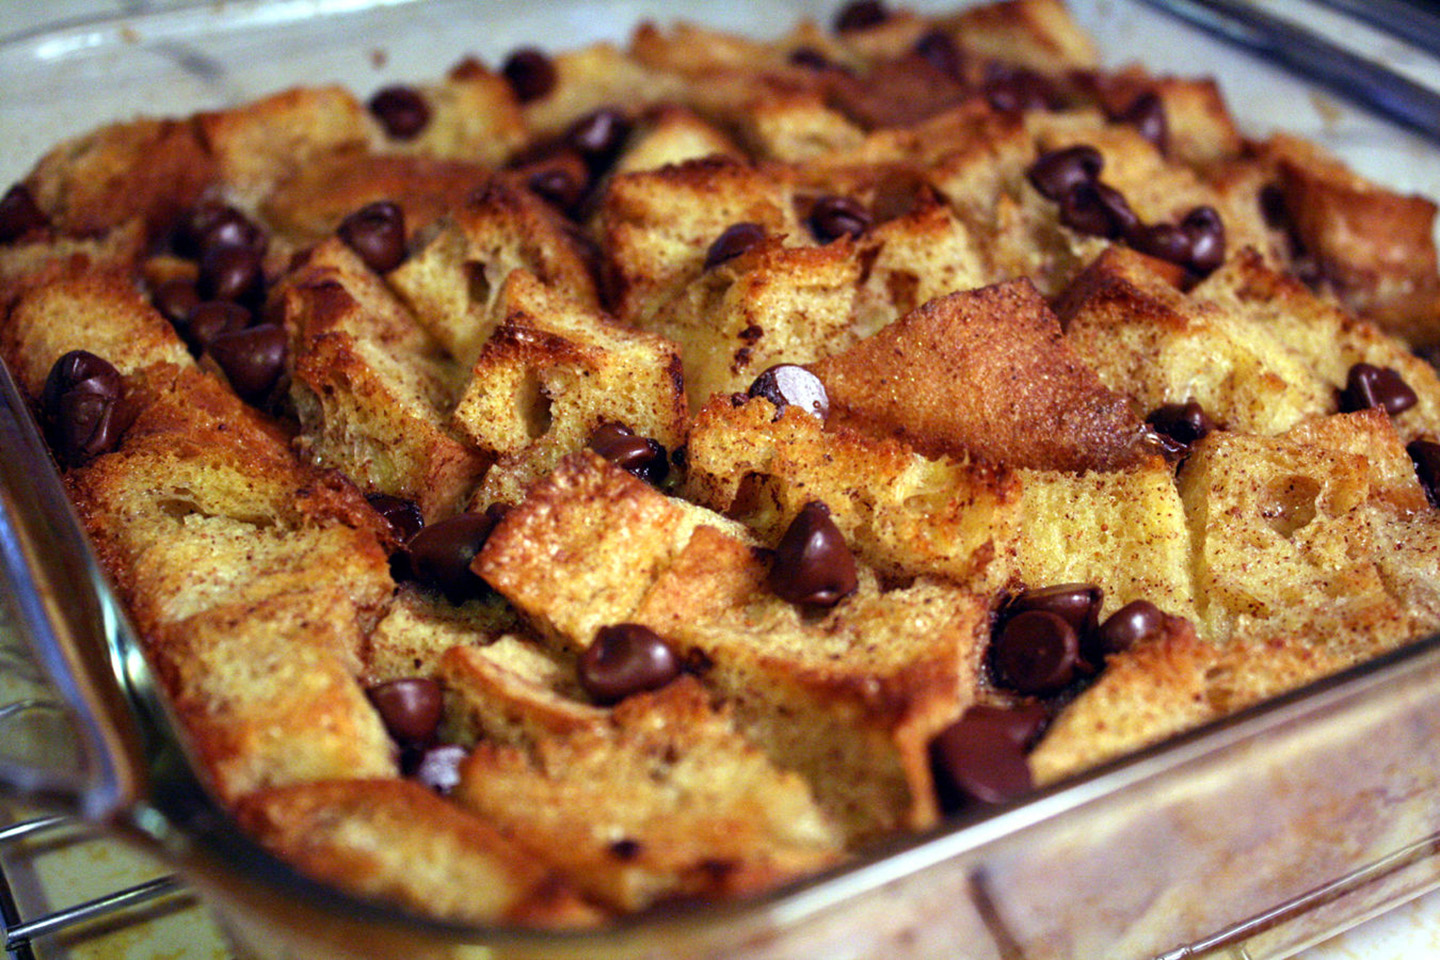

In [ ]:
image7_name = './googled images to test model/bpud.jpg'
Image(image7_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image7_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[9.8837316e-02 6.5780652e-01 9.5933387e-03 8.4933117e-03 6.3630871e-02
  1.5257801e-02 1.2745916e-04 2.5617416e-04 2.5041931e-04 1.4574677e-01]]
1


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

bread pudding


### Predicting carrot cake

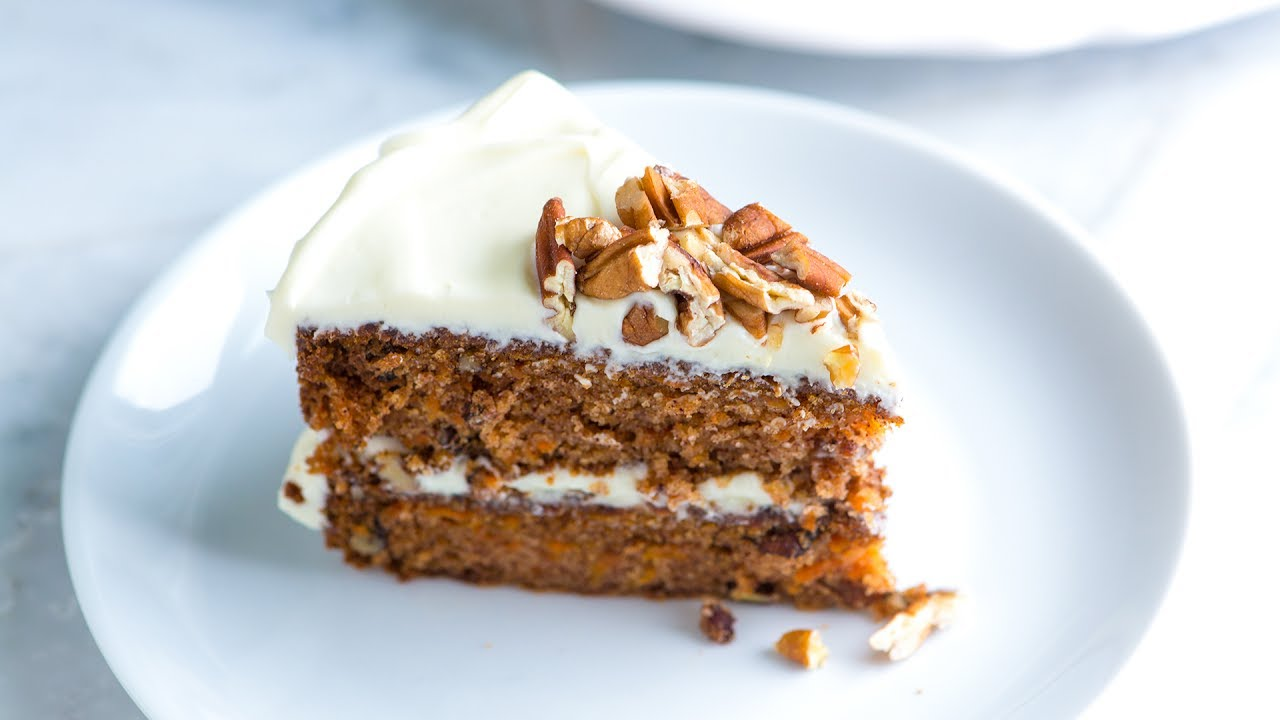

In [ ]:
image8_name = './googled images to test model/ccake.jpg'
Image(image8_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image8_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[3.9996670e-04 5.2882478e-06 9.8296148e-01 5.8874142e-05 8.3149066e-03
  4.9383356e-08 9.5775468e-09 2.7863136e-05 3.9164153e-08 8.2316324e-03]]
2


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

carrot cake


### Predicting cheesecake

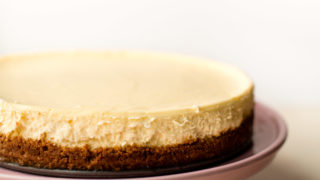

In [ ]:
image9_name = './googled images to test model/chcake.jpg'
Image(image9_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image8_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[3.9996670e-04 5.2882478e-06 9.8296148e-01 5.8874142e-05 8.3149066e-03
  4.9383356e-08 9.5775468e-09 2.7863136e-05 3.9164153e-08 8.2316324e-03]]
2


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

carrot cake


Here we see that our model has misclassified cheesecake as carrot cake. This seems reasonable as the colours of cheesecake in this picture look similar to that of carrot cake.

### Predicting red velvet cake

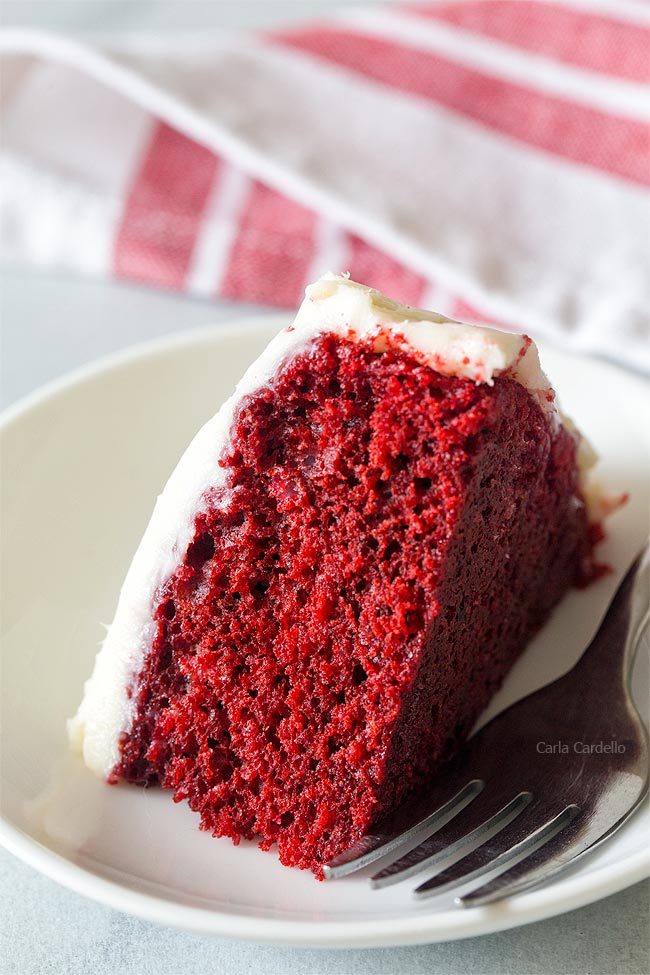

In [ ]:
image10_name = './googled images to test model/rvcake.jpg'
Image(image10_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image10_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b0.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.2862588e-06 1.0940479e-05 2.1292821e-05 7.4921286e-04 1.7045975e-01
  3.4902275e-06 1.2008762e-03 7.9513395e-01 8.5588126e-06 3.2410707e-02]]
7


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

red velvet cake


This is not an exhaustive test, but from our limited testing, we conclude that our model can generalise well to most classes, but does misclassify certain classes. More training might be needed for it to better distinguish classes like carrot cake from cheesecake. However, overall our model seems to be able to generalise unseen data well, correctly predicting 9 out of 10 classes.

## Saving best model and weights

In [ ]:
#saving model and weights

model_b0.save('final_model.h5', save_format='h5')

## Conclusions
To address our problem statement, we have built a 5 class Japanese Food classifier with validation accuracy of around 85% and a 10 class desserts classifier with a validation accuracy rate of around 77%. There is definitely room for improvement, as our model still tends to misclassify some categories, such as predicting cheesecake as carrot cake.


### Room for improvement
If we were to deploy such a solution to production and eventually for usage in unmanned retail and fnb stores, more work will need to be done, in terms of the following: <br>
1) Training the model with more data of the food at different camera angles and heights <br>
2) Training the model with more classes if we have more computational power and time<br>
3) Tuning the model for better accuracy by varying the layers to freeze during training, and use other techniques such as image augmentation or CutMix. <br>
4) Creating an object detection model so that we can count the quantity of items detected.